<a href="https://colab.research.google.com/github/ekourkchi/incNET-data/blob/master/CNN_inc_CGG6_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
data = np.load('/content/drive/My Drive/data_64x64.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

51


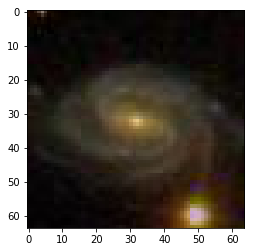

In [3]:
i = 750
print labels_[1][i]
plt.imshow(images_[i])

(array([3220., 2460., 2532., 3296., 3188., 4936., 4940., 5692., 5208.,
        7552.]),
 array([51. , 54.9, 58.8, 62.7, 66.6, 70.5, 74.4, 78.3, 82.2, 86.1, 90. ]),
 <a list of 10 Patch objects>)

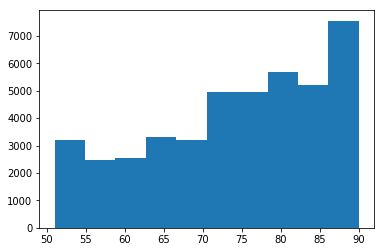

In [4]:
plt.hist(labels_[1][labels_[1]>50])

(60468, 64, 64, 3)
(43024, 64, 64, 3)
65


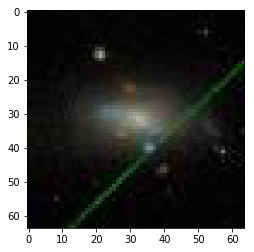

In [5]:
print images_.shape
ix, = np.where(labels_[1]>50)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

print images_c.shape

i = 100
plt.imshow(images_c[i])
print labels_c[i]


In [6]:
print(len(set(labels_c)))
print np.min(labels_c)
print np.max(labels_c)


40
51
90


In [120]:
from sklearn.model_selection import train_test_split

images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, labels_c, pgcIDs_c, test_size=0.40)

notUnique = np.isin(pgcIDs_test, pgcIDs_train)
Unique = np.logical_not(notUnique)

images_train = np.concatenate((images_train, images_test[notUnique]))
labels_train  = np.concatenate((labels_train, labels_test[notUnique]))
pgcIDs_train = np.concatenate((pgcIDs_train, pgcIDs_test[notUnique]))

images_test = images_test[Unique]
labels_test = labels_test[Unique]
pgcIDs_test = pgcIDs_test[Unique]


In [121]:
print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)
print(pgcIDs_train.shape)
print(pgcIDs_test.shape)

(41916, 64, 64, 3)
(1108, 64, 64, 3)
(41916,)
(1108,)
(41916,)
(1108,)


In [122]:
np.isin(pgcIDs_test, pgcIDs_train).sum()

0

In [123]:
print images_train.shape , labels_train.shape
print images_test.shape , labels_test.shape


(41916, 64, 64, 3) (41916,)
(1108, 64, 64, 3) (1108,)


(array([0.02591873, 0.00740535, 0.01295936, 0.01851338, 0.01758771,
        0.03424975, 0.02869573, 0.03610108, 0.03980376, 0.03517541]),
 array([51. , 54.9, 58.8, 62.7, 66.6, 70.5, 74.4, 78.3, 82.2, 86.1, 90. ]),
 <a list of 1 Patch objects>)

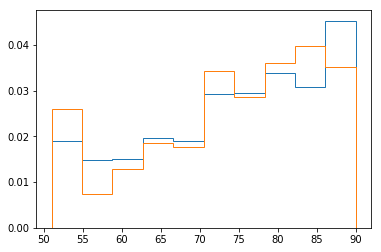

In [124]:
plt.hist(labels_train, histtype='step', label='train', density=True)
plt.hist(labels_test, histtype='step', label='test', density=True)

In [125]:
print labels_train

[88 86 67 ... 54 71 82]


In [126]:
labels_train  = labels_train - 51
labels_test   = labels_test - 51
images_test   = images_test / 255.
images_train  = images_train / 255.

In [135]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

import numpy as np
def vgg6(input_shape=(64, 64, 3), n_classes= 40):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.20, seed=0))

    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1_'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2_'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.20, seed=0))    

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.20, seed=1))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.20, seed=2))

    model.add(tf.keras.layers.Dense(128, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.25, seed=3))
    
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [143]:
import keras.backend as K

def custom_loss(y_true, y_pred):

    # yt = K.argmax(y_true, axis = 1 )
    yt = y_true
    yp = K.argmax(y_pred, axis = 1 )
  
    yt = K.cast(yt, dtype='float64')
    yp = K.cast(yp, dtype='float64')

    # calculate loss, using y_pred
    loss = K.abs(yp - yt)

    # summing both loss values along batch dimension 
    loss = K.mean(loss, -1)        # (batch_size,)
        
    return  K.sqrt(loss)

# loss=custom_loss
# loss = 'sparse_categorical_crossentropy'
vgg_model = vgg6()
vgg_model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', custom_loss])
n_epochs = 30
vgg_model.summary()
vgg_model_history = vgg_model.fit(images_train, labels_train, 
                                  epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_data=(images_test, labels_test),
                                  shuffle=False)


Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 62, 62, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
dropout_128 (Dropout)        (None, 30, 30, 16)        0         
_________________________________________________________________
conv1_ (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
conv2_ (Conv2D)              (None, 26, 26, 16)        2320      
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 13, 13, 16)        0      

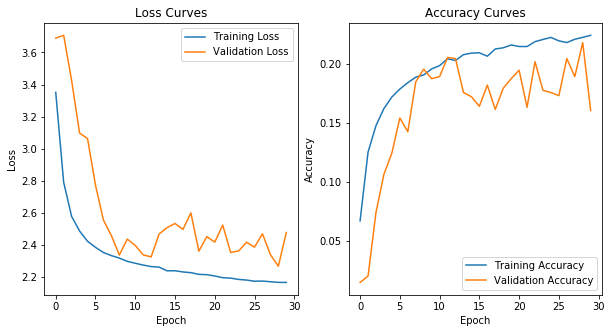

In [144]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
# plot the training history
# print vgg_model.history.history['loss']

plot_model_history(vgg_model.history)
  

In [145]:
inc_p = vgg_model.predict(images_test)
inc_m = labels_test +51


N = images_test.shape[0]

inc_p = np.argmax(inc_p, axis=1) + 51

71
70


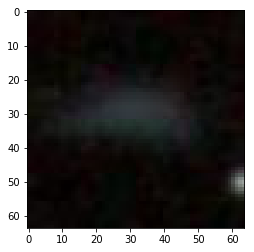

In [146]:
i = 90
print inc_p[i]
print inc_m[i]
plt.imshow(images_test[i])

3.777426778720146
3.2165885303934574


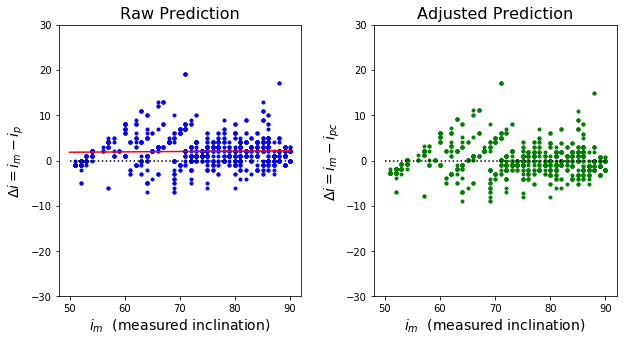

In [147]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print np.sqrt(np.mean((d)**2))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print np.sqrt(np.mean((d_)**2))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

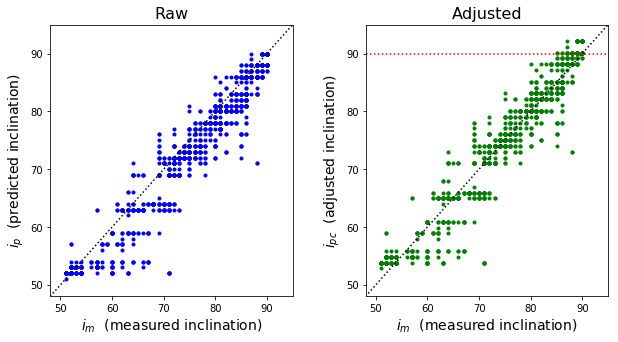

In [148]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, 'b.')
ax[0].plot([48,95],[48,95], 'k:')
ax[0].set_xlim(48,95)
ax[0].set_ylim(48,95)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([48,95],[48,95], 'k:')
ax[1].set_xlim(48,95)
ax[1].set_ylim(48,95)
ax[1].plot([48,95],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)

In [142]:
vgg_model.save("/content/drive/My Drive/CNN_inc_VGG6_classify.h5")
print("Saved model to disk")

Saved model to disk
